# M1 Loading and Preparing the Dataset

## Objective

The goal of this preliminary milestone is to load and preprocess the dataset. The raw text is noisy and we want to remove nonwords and non-ASCII characters, keep punctuation to a minimum, and reduce the overall vocabulary of the corpus.

- Although this corpus is not as noisy as a text directly extracted from a social network (for example, Twitter or Facebook), it is still not as structured as academic papers or newspaper articles. Furthermore, the corpus displays some interesting particularities, such as the presence of HTML markup and LaTeX-formatted equations. The corpus is also rich in specific entities, names of theorems, and statistical test algorithms, and it mixes colloquial writing with more formally structured paragraphs.


- The garbage-in, garbage-out golden rule of machine learning is also applicable to language models. Simply put, if we skip the preprocessing/cleaning part of the project, the vocabulary of our language model will be too vast and noisy to make any sense. Generated text, for instance, may mix in mathematical symbols with punctuation signs or random HTML tags and numbers. By reducing the volume of the corpus vocabulary, we increase the relevance and quality of the generated text and improve the reliability of sentence selection based on their respective probabilities. We also reduce the memory imprint of our code and its execution time.


- Preprocessing the text to reduce noise and vocabulary size is an iterative process. You should start simple and further refine the preprocessing steps after building and evaluating your first language models.~

In [12]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer

## Load the dataset into a pandas DataFrame

In [3]:
df = pd.read_csv('~/data/stackexchange_812k.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812132 entries, 0 to 812131
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   post_id     812132 non-null  int64  
 1   parent_id   75535 non-null   float64
 2   comment_id  553076 non-null  float64
 3   text        812132 non-null  object 
 4   category    812132 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 31.0+ MB


In [5]:
df.head()

,post_id,parent_id,comment_id,text,category
0,1,NaN,NaN,Eliciting priors from experts,title
1,2,NaN,NaN,What is normality?,title
2,3,NaN,NaN,What are some valuable Statistical Analysis op...,title
3,4,NaN,NaN,Assessing the significance of differences in d...,title
4,6,NaN,NaN,The Two Cultures: statistics vs. machine learn...,title


In [6]:
df.text.sample(10)

498456    S. Haykin, Adaptive Filter Theory, 5th Edition...
89243     Understanding the violation of the independenc...
15152     Confusion over lmer and p-values: how do p-val...
15904     Is a large control sample better than a balanc...
170280    <p>Figure 1 there clarifies things a bit. All ...
649371    Fair enough, I agree/stand corrected. I still ...
112754    <p>There are some angles on this to consider. ...
810641                  Any question @RiturajSinghRathore ?
120845    <p>Your example is a very good one because it ...
66418     Question about notation of expectation operato...
Name: text, dtype: object

## Use regular expressions to remove elements that are not words, such as HTML tags, LaTeX expressions, URLs, digits, and line returns.

In [7]:
HTML = "<[^>]*>"
LATEX = "\$[^>]*\$"
URLS = "http\S+"
CRS = "[\r\n]+"
DIGITS = "\$[^>]*\$"
SPACES = "\s\s+"
PUNCT = '"#$%&()*+/:;<=>@[\\]^_`{|}~”“'
pattern = r"[{}]".format(PUNCT)

def clean_text(text):
    """
        text: a string        
        return: modified initial string
    """
    text = re.sub(HTML,' ', text)
    text = re.sub(LATEX,' ', text)
    text = re.sub(URLS,' ', text)
    text = re.sub(CRS,' ', text)
    text = re.sub(DIGITS,' ', text)
    text = re.sub(pattern,' ', text)
    text = re.sub(SPACES,' ', text)
    text = re.sub(DIGITS,' ', text)
    return text.strip()

In [8]:
clean_text('Formulate hypotheses when $\mu_A < \mu_B$')

'Formulate hypotheses when'

In [9]:
clean_text('See my response to <a href="https://stackoverflow.com/questions/2252144/datasets-for-running-statistical-analysis-on')

'See my response to a href'

In [10]:
# Sample of comments
for p in df[df.category == 'comment'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
May fit better under: http://stats.stackexchange.com/questions/1906/data-mining-conferences?
--------------------
$X$ is the mean of something and is distributed as $Exp(1)$ and Y is the actual value (i.e. not the mean) with parameter $X = x$ such that $Y | X = x$ is distributed as $Pois(X = x)$. I'll give my own answer right now and hopefully, you can confirm it.
--------------------
What result do you get if you just use a random forest regression model instead of the classifier and then regressor?


In [11]:
df.text = df.text.apply(clean_text)

In [12]:
# Post clean sample of comments
for p in df[df.category == 'comment'].text.sample(3).values:
  print('-' * 20)
  print(p)

--------------------
Glen b and samooch and Marius The formula expansion of factor symbol factor time will include main effects for both symbol and time. Furthermore, the 0 will only change the labeling of the effects. Instead of an Intercept term you will see the estimates for interaction of the lowest levels for symbol and time. If you wanted to avoid estimating a main effect for time you would need to use factor symbol factor time
--------------------
I don't understand your question. Are you asking what does it mean if all variables are most strongly correlated with PC1?
--------------------
Yes, I didn't know the term eigenface but that's what they are when I have just one output neuron with 6 output neurons I still get faces but they are much more noisy .


## Remove texts that contain blanks only.

In [13]:
df.text.count()

812132

In [14]:
df[df.text.str.len() == 0].text.count()

1422

1422 out of 812132 entries have a zero length text.

In [15]:
df = df[df.text.str.len() > 0]

In [16]:
df.text.count()

810710

## Remove texts that are extremely large or too short to add any information to the model. 

We want to keep paragraphs that contain at least a few words and remove the paragraphs that are composed of large numerical tables.

In [13]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
df['tokens'] = df.text.apply(lambda t : tokenizer.tokenize(t.lower()))

In [18]:
df['n_tokens'] = df.tokens.apply(len)

In [19]:
df.n_tokens.describe()

count    810710.000000
mean         63.246199
std         122.586727
min           1.000000
25%          16.000000
50%          36.000000
75%          72.000000
max       14835.000000
Name: n_tokens, dtype: float64

In [20]:
df.n_tokens.max()

14835

In [21]:
df = df[(df.n_tokens > 4) & (df.n_tokens < 5000)].reset_index(drop = True)
df.shape

(791172, 7)

## Use a tokenizer to create a version of the original text that is a string of space-separated lowercase tokens. 

For instance,

- Thank you!, This equation y = ax + by=ax+b, is very helpful.

    would be transformed to:

    thank you ! this equation , is very helpful .

- “retrieve a distance matrix” is a matter of coding. It also might be irrelevant: one can imagine creative answers.

    becomes, if you choose to remove double quotes from the original text:

    retrieve a distance matrix is a matter of coding. it also might be irrelevant : one can imagine creative answers .

Note that punctuation signs (, . : !) are also represented as tokens.

In [14]:
from nltk import word_tokenize
from nltk import Text

In [23]:
def space_separated_lower(text):
    tokens = word_tokenize(text.lower())
    return " ".join(list(filter(lambda x: x not in ['“', "”"], tokens)))

In [24]:
text = '“retrieve a distance matrix” is a matter of coding. It also might be irrelevant: one can imagine creative answers.'
space_separated_lower(text)

'retrieve a distance matrix is a matter of coding . it also might be irrelevant : one can imagine creative answers .'

In [25]:
df['tokens'] = df.text.apply(space_separated_lower)

## Export the resulting DataFrame into a CSV file.

In [27]:
import csv
df.to_csv("../data/stackexchange_cleaned.csv", quoting = csv.QUOTE_ALL, index = False)

# M2 N-gram Language Model

## Objective

In this second milestone of the liveProject, the objective is to build an n-gram language model that is defined by the probabilities of all the n-grams in the corpus. Assuming that each token only depends on n-1 previous tokens, the language model is fully defined by the probability of any token in the corpus given its n-1 previous tokens (the prefix).

You will use the language model to complete the following tasks:

Generate text and complete queries from sequences of n-grams, using temperature sampling to tune the randomness of the generated text.
Calculate the probability of a sentence and select the most probable sentence among several candidates.
Score the quality of the language model using perplexity.
Handle out-of-vocabulary (OOV) tokens with Laplace smoothing.

Although simple in its approach, an n-gram language model with additive smoothing is a fast and reliable way to build a model that you can exploit for simple tasks such as query completion and sentence selection, provided that the training dataset is large and specific enough for the domain of interest.

This first language model will serve as a baseline for the more complex language models that we will create in subsequent tasks. It also underlines the different problems and challenges inherent to any NLP task, such as handling out-of-vocabulary tokens, the importance of cleaning the original raw data, and the quality assessment of a language model.

An n-gram model is defined as the probabilities of all the n-grams in the corpus. Under certain Markovian independence assumptions, this is equivalent to evaluating the probability of any token given its n-1 previous tokens (the prefix). For a given prefix, the probabilities of all the following tokens add up to 1 and constitute the probability distribution of the prefix.

For instance, in our current corpus, the prefix “how many” may be followed by the words “people,” “times,” or “ways,” with respective frequencies of 0.46, 0.31, and 0.23, while the prefix “the model” is followed by the words “parameters” or “is” or a period, with frequencies 0.43, 0.36, and 0.21, and so forth.

In an n-gram language model, the probability of a token given a prefix of n-1 tokens is given by its maximum likelihood estimate (MLE).

In [15]:
# Set some global parameters

# Displaying all columns when displaying dataframes
pd.options.display.max_columns = None

# We will work with trigrams 
ngrams_degree = 3


## Split the dataset into a training and a testing subset. 

Use the category “title” for the testing set and the categories “comment” and “post” for the training set. The short length of titles will make them good candidates later as seeds for text generation.

In [4]:
df = pd.read_csv('../data/stackexchange_cleaned.csv').sample(frac=1).reset_index(drop = True)

In [5]:
df.shape

(791172, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791172 entries, 0 to 791171
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   post_id     791172 non-null  int64  
 1   parent_id   74519 non-null   float64
 2   comment_id  542016 non-null  float64
 3   text        791172 non-null  object 
 4   category    791172 non-null  object 
 5   tokens      791172 non-null  object 
 6   n_tokens    791172 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 42.3+ MB


In [8]:
df.text[:5]

0    I am working on a machine control project. We ...
1    I have a set of sea surface temperature SST mo...
2    This is assuming , which does not seem realist...
3    Adolphe Quetelet for his work on the average m...
4    Transformation of X is for linear relation bet...
Name: text, dtype: object

In [16]:
df['tokens'] = df.tokens.apply(lambda t : tokenizer.tokenize(' '.join(t)))

In [19]:
df.sample(5).tokens.values

array([list(['iagocarvalho', 'i', 'am', 'not', 'sure', '.', 'i', 'don', "'", 't', 'think', 'there', 'is', 'any', '...']),
       list(['whuber', ',', 'yes', ',', 'that', 'too']),
       list(['i', 'don', "'", 't', 'see', 'the', 'commands', 'you', 'used', 'to', 'scale', 'the', 'data', '.', 'perhaps', 'there', 'is', 'an', 'error', 'there', '.', 'if', 'you', 'plot', 'each', 'scaled', 'variable', 'versus', 'its', 'corresponding', 'raw', 'variable', ',', 'you', 'should', 'get', 'nothing', 'but', 'straight', 'lines', '.', '...', 'oh', ',', 'and', 'if', 'you', 'scaled', "'", 'result', "'", 'too', ',', 'it', "'", 's', 'no', 'wonder', ',', 'because', 'you', "'", 're', 'no', 'long', 'modeling', 'the', 'sme', 'response', 'variable', '.', 'either', 'way', ',', 'we', 'need', 'more', 'details', 'on', 'what', 'you', 'mean', 'by', 'scaling', '.']),
       list(['user112758', 'could', 'you', 'post', 'the', 'equations', 'in', 'question', '?', 'i', "'", 'm', 'afraid', 'i', 'don', "'", 't', 'have', 'the',

In [20]:
# split the dataset into train and testing subset
df_train = df[df.category.isin(['post', 'comment'])].copy()
df_test = df[df.category.isin(['title'])].copy()

In [21]:
# Display the dimensions of the dataframe 
print("-- Training set: {}\n".format(df_train.shape))
# and the 1st 5 lines
print(df_train.head())

print("\n-- Testing set {}\n".format(df_test.shape))
print(df_test.head())

-- Training set: (707373, 7)

   post_id  parent_id  comment_id  \
0    16054        NaN         NaN   
1     9739        NaN         NaN   
2   313248        NaN    762205.0   
3     5596     5115.0         NaN   
4   372739        NaN    700543.0   

                                                text category  \
0  I am working on a machine control project. We ...     post   
1  I have a set of sea surface temperature SST mo...     post   
2  This is assuming , which does not seem realist...  comment   
3  Adolphe Quetelet for his work on the average m...     post   
4  Transformation of X is for linear relation bet...  comment   

                                              tokens  n_tokens  
0  [i, am, working, on, a, machine, control, proj...       147  
1  [i, have, a, set, of, sea, surface, temperatur...       253  
2  [this, is, assuming, ,, which, does, not, seem...        12  
3  [adolphe, quetelet, for, his, work, on, the, a...        38  
4  [transformation, of, x, is, 

## Build the matrix of prefix—word frequencies.

- Use the ngrams function from nltk.utils to generate all n-grams from the corpus.


- Set the following: left_pad_symbol = \<s> and right_pad_symbol = \</s>.

### Counting bigrams and following tokens

We build a counts object defined as a defaultdict(Counter). 

Taking into account all trigrams (ngrams_degree = 3) that we break into prefix (bigrams) followed by single tokens. 

The counts object will have the bigrams as keys and for each key a Counter of all the potential tokens. 

For instance, if the corpus contains a 100 instances of "*how many people*" and a 120 instances of "*how many times*" we would get the following entry:

    counts[('how', 'many')] = Counter('people': 100, 'times': 120, .... )

Similarly if the corpus contains "*the model is*" 500 times and "*the model parameters*" 200 times, we end up with:

    counts[('the', 'model')] = Counter('is': 500, 'parameters': 200, .... )

To split the tokens into bigramns we use the [ntlk.ngrams](https://www.nltk.org/api/nltk.html#nltk.util.ngrams) function:


    Return the ngrams generated from a sequence of items, as an iterator.
    For example:

    >>> from nltk.util import ngrams
    >>> list(ngrams([1,2,3,4,5], 3))
    [(1, 2, 3), (2, 3, 4), (3, 4, 5)]

The next cell should take a couple of minutes.

Note that we build the mode on the training subset df_train and leave the testing subset aside.

In [82]:
from collections import defaultdict, Counter
from nltk.util import ngrams
from tqdm import tqdm
import numpy as np

In [177]:
def n_grams(sentence, ngrams_degree=3):
    return ngrams(
        sentence, 
        n = ngrams_degree,  
        pad_right = True, 
        pad_left = True, 
        left_pad_symbol = "<s>", 
        right_pad_symbol = "</s>")

In [179]:
sentence = "the difference between the two approaches is discussed here"
list(n_grams(sentence.split(), 4 ) )[:10]

[('<s>', '<s>', '<s>', 'the'),
 ('<s>', '<s>', 'the', 'difference'),
 ('<s>', 'the', 'difference', 'between'),
 ('the', 'difference', 'between', 'the'),
 ('difference', 'between', 'the', 'two'),
 ('between', 'the', 'two', 'approaches'),
 ('the', 'two', 'approaches', 'is'),
 ('two', 'approaches', 'is', 'discussed'),
 ('approaches', 'is', 'discussed', 'here'),
 ('is', 'discussed', 'here', '</s>')]

In [163]:
counts = defaultdict(Counter)
for tokens in tqdm(df_train.tokens.values):
    for ngram in n_grams(tokens):      
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        counts[prefix][token] +=1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 705964/705964 [01:16<00:00, 9262.12it/s]


In [180]:
print("we have {} bigrams".format(len(counts.keys())))

we have 3332935 bigrams


In [181]:
import random

for i in range(5):
    prefix = random.choice(list(counts.keys()))
    print("{}: \t{}".format(prefix,counts[prefix]))

('chance', 'versus'): 	Counter({'actual': 1, 'probability': 1, 'systematic': 1, 'randomness': 1})
('in', 'statmod'): 	Counter({'and': 1})
('players', 'lurking'): 	Counter({'around': 1})
('causational', 'research'): 	Counter({'.': 1})
('based', 'ensemble'): 	Counter({'methods': 2, 'method': 1})


In [36]:
tokens_count = [ len(v)   for k,v in counts.items() ]

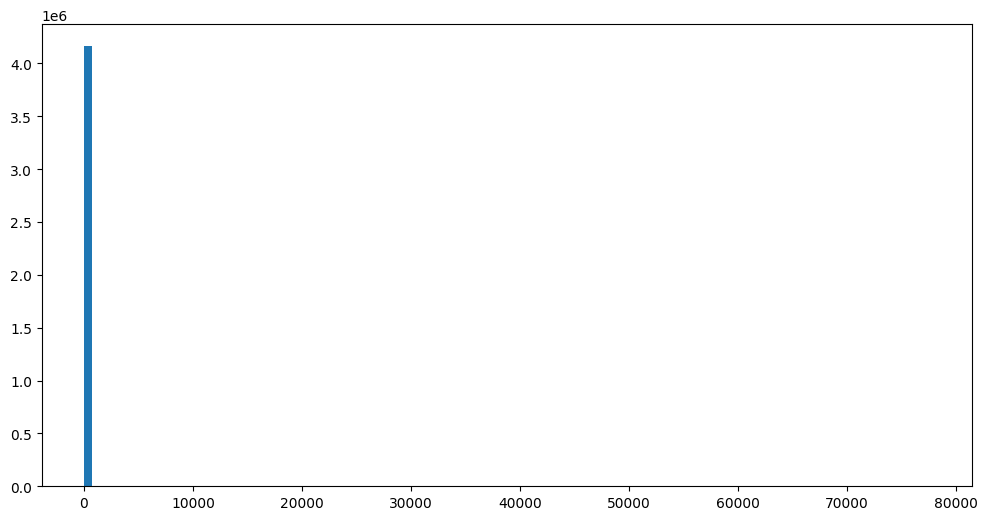

In [39]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.hist(tokens_count, bins = 100);

In [40]:
bigrams_with_single_tokens = [ k   for k,v in counts.items() if len(v) == 1 ]
bigrams_with_two_tokens = [ k   for k,v in counts.items() if len(v) == 2 ]

print("{} bigrams_with_single_tokens".format(len(bigrams_with_single_tokens)))
print("{} bigrams_with_two_tokens".format(len(bigrams_with_two_tokens)))

2839506 bigrams_with_single_tokens
511760 bigrams_with_two_tokens


In [182]:
tokens_dict = { k:len(v)   for k,v in counts.items() if len(v) > 10000 }
tokens_dict

{('<s>', '<s>'): 11564, ('of', 'the'): 10815}

In [51]:
for prefix, tokens in counts.items():
    print("prefix=", prefix, "\ntokens=", tokens.most_common(10))
    print(sum(counts[prefix].values()))
    break

prefix= ('<s>', '<s>') 
tokens= [('i', 122361), ('the', 31612), ('thanks', 22184), ('you', 22096), ('this', 17342), ('it', 16576), ('if', 16295), ('what', 14034), ('thank', 13274), ('yes', 12196)]
707373


###  token / prefix probabilities

To obtain token / prefix probabilities using the Maximum Likelihood Estimator, we must simply normalize each (prefix - token) count by the total number of the prefix occurence. 

$$p(token / prefix) = \frac{count(prefix + token)} {count(prefix)}$$


Keeping the same defaultdict(Counter) structure for the freq object, we should obtain something similar to 


    freq[('how', 'many')] = {'people': 0.14, 'times': 120, .... }

with 
* p(people / how many) = c('how many people') / c('how many') 
* p(times / how many) = c('how many times') / c('how many')

In [183]:
freq = defaultdict(dict)
for prefix, tokens in counts.items():
    total = sum(counts[prefix].values())
    for token, count in tokens.items():
        freq[prefix][token] = count / total

In [184]:
for i in range(5):
    prefix = random.choice(list(freq.keys()))
    print("{}: \t{}".format(prefix,freq[prefix]))

('tests', 'performs'): 	{'equally': 0.3333333333333333, 'really': 0.3333333333333333, 'one': 0.3333333333333333}
('variable', 'alongside'): 	{'several': 0.25, 'the': 0.25, 'an': 0.5}
('philosophies', 'diverge'): 	{'many': 1.0}
('determined', 'groups'): 	{'it': 1.0}
('basic', 'patterns'): 	{'very': 0.5, 'don': 0.5}


## Write a text generation function with the following features:

- Takes a bigram as input and generates the next token


- Iteratively slides the prefix over the generated text so that the new prefix includes the most recent token; generates the next token


- To generate each next token, samples the list of words associated with the prefix using the probability distribution of the prefix


- Stops the text generation when a certain number of words have been generated or the latest token is a \</s>

In [94]:
def generate(text, n_words = 40):
    for i in range(n_words):
        prefix = tuple(text.split()[-ngrams_degree+1:])
        if len(freq[prefix]) == 0:
            break
        candidates  = list(freq[prefix].keys())
        probabilities = list(freq[prefix].values())
        text += ' ' + np.random.choice(candidates, p = probabilities)
        if text.endswith('</s>'):
            break
    return text

In [78]:
tuple('the model'.split()[-ngrams_degree+1:])

('the', 'model')

In [95]:
text      = 'the model'
print()
print(generate(text))

print()
text      = 'that distribution'
print(generate(text))

print()
text      = 'to determine'
print(generate(text))


the model for example , library , but still successful in analyzing . for more information on the previous thread at cdf raised to a normal distribution function , so here it ' s also shiny </s>

that distribution , type , or a different q -- not only x property of the seasonal ma coefficients . these values are distributed over time are statistically signficantly greater than one definition of causality ? </s>

to determine the lines join at s0 which may be i 1 here ? pc1 or pc2 , pt3 pc3 , and produced something different values of both groups ? in a certain application of this function assumes the data ? </s>


## Write a function that can estimate the probability of a sentence and use it to select the most probable sentence out of several candidate sentences.


Split the sentence into trigrams and use the chain rule to calculate the probability of the sentence as a product of the bigrams—tokens probabilities.

- Estimate the probability of a sentence and use it to select the most probable sentence out of several candidate sentences.

- Similar to the above process calculate the candidates and initial_probabilites from freq dictionary

- Here we will modify the initial_probabilites using temperature and normalizing it to generate random candidates. 

### Temperature sampling

As you may have noticed, for some bigrams, one particular token may be much more frequent than the others potential tokens. 

For instance:

* ('building', 'machine'): 	{'learning': 0.875, 'classification': 0.125}

when generating the next token based on the bigram "*building machine*", most of the times the word "learning" will be chosen instead of "classification".

In order to compensate these imbalances and improve the chances of less frequent tokens to be chosen we can sample with temperature.

In order to increase the randomness of the next token selection given a prefix, we can flatten the distribution using the temperature $$\tau$$ to define a new probability distribution as such:

$$f_{\tau}(p_i) = \frac{ p_i^{\frac{1}{\tau}} }{ \sum_j p_j^{\frac{1}{\tau}} }$$

See [this post](https://stats.stackexchange.com/questions/255223/the-effect-of-temperature-in-temperature-sampling) for a more in-depth explanation on temperature sampling.

In [98]:
def generate_temp(text, temperature = 1, n_words = 30):
    for i in range(n_words):
        prefix = tuple(text.split()[-ngrams_degree+1:])
        if len(freq[prefix]) == 0:
            break
        candidates  = list(freq[prefix].keys())
        initial_probabilities = list(freq[prefix].values())
        denom   = sum([p ** temperature for p in initial_probabilities])
        probabilities  = [p ** temperature / denom  for p in initial_probabilities]
        text  += ' ' + np.random.choice(candidates, p = probabilities)
        if text.endswith('</s>'):
            break
    return text

In [99]:
text  = 'the model'
# text  = 'to determine'
# text  = 'not sure'

for tau in [0.01, 0.5, 1, 3, 10]:
    print(tau)
    print(generate_temp(text, temperature = tau))

0.01
the model those ? note to myself what you represent negative intra - layer is with any application in retrieval , a confusion which is suggestive , it implicitly confuses estimation with
0.5
the model conditioned on these topics monte carlo approach by pesaran et al were the output contains 7 binary questions . yes value 1 0 14098 . 1 plus a column real
1
the model predictor predictor information is relevant to the approach i am trying to help people answer no . i can find some good opinion from you . edit yes , the
3
the model is not the same as the number of observations . </s>
10
the model . </s>


## Implement the perplexity scoring function for a given sentence and for the training corpus.

Let's now implement a way to measure the quality of our model.

The idea is to estimate the probability of a test sentence given our model. 
An uncommon sentence should be less probable than a common one.


Notes : 
  1. At this point the sentence should exist in the corpus. Our model does not know yet how to handle out-of-vocabulary (OOV) bigrams, trigrams or tokens.
  2. To avoid the problem of underflow caused by multiplying multiple very small floats, we work in the log space:

So instead of calculating perplexity with (case ngrams_degree = 3):
 
$$PP(w_{1},\cdots, w_N) = ( \prod_{i = 3}^{N} \frac{1}{ p(w_i/ w_{i-2}w_{i-1} )} )^{\frac{1}{N}}$$

We compute

$$PP(w_{1},\cdots, w_N) = \exp [ - \frac{1}{N} {\sum_{i = 3}^{N} \log {p(w_i/ w_{i-2}w_{i-1}} } ) ]$$

In [109]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

def perplexity(sentence):
    sentence = tokenizer.tokenize(sentence.lower())
    N = len(sentence)
    logprob = 0

    for ngram in n_grams(sentence): 
        try:
            prefix = ngram[:ngrams_degree-1] 
            token = ngram[ngrams_degree-1]
            logprob += np.log(freq[prefix][token])
        except:
            pass

    return np.exp(- logprob / N)

In [110]:
sentence = "the difference between the two approaches is discussed here"
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

sentence = "this question really belongs on a different site"
print()
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

sentence = "The function may only be linear in the region where the points were taken"
print()
print("[perplexity {:.2f}] {}".format(perplexity(sentence), sentence))

[perplexity 22.95] the difference between the two approaches is discussed here

[perplexity 38.30] this question really belongs on a different site

[perplexity 73.33] The function may only be linear in the region where the points were taken


## Implement additive Laplace smoothing to give a non-zero probability to missing prefix—token combinations when calculating perplexity.

### Out of Vocabulary (OOV) 

The main weakness of our model so far is that it does not know how to handle elements that are not already in the original corpus.

Since both when generating text and when calculating perplexity we use the count of the prefix in the corpus, when that prefix is missing, the counts = 0  which causes problems with logs and divisions.

To remediate to that problem we can artificially assign a probability (although a very low one) to missing ngrams and tokens.

This method is called Laplace smoothing. It relies on calculating the frequency of a token / prefix with:

$$ p(token / prefix) = \frac{ count( prefix + token) + \delta}{count(prefix) + \delta \times |N| }$$


Where 

* N is the total number of prefixes in the model
* delta is an arbitrary number 

When the prefix is missing from the original corpus, the probability of a token / prefix will now be:

$$p(token / prefix) = \frac{1} { | N |}$$

Let's implement that perplexity with Laplace Smoothing


In [111]:
def perplexity_laplace(sentence, delta = 1):
    sentence = tokenizer.tokenize(sentence.lower())
    N = len(sentence)
    logprob = 0
    for ngram in n_grams(sentence): 
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        if prefix in list(counts.keys()):
            total = sum(counts[prefix].values())
            if token in counts[prefix].keys():
                logprob += np.log((counts[prefix][token] + delta)/ (total + delta * N))
            else:
                logprob += np.log((delta) / (total + delta * N ))
        else:
            logprob += - np.log(N)
  
    return np.exp(- logprob / N)

In [113]:
# calculate the perplexity of sentences that were not present in the original corpus.

sentence = "this model belongs on a different planet"
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 10), sentence))

sentence = "this question really belongs on a different site."
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 10), sentence))

[perplexity 145.18] this model belongs on a different planet
[perplexity 35.54] this question really belongs on a different site.


## Calculate the perplexity of the language model on the test set composed of titles.

Perplexity on the test corpus and sentence probability.

How do we calculate the perplexity of a model on a test corpus?

Let's say we have *m* sentences in the corpus, the perplexity of the corpus is given by 

$$ PP(Corpus) = P(S_1, \cdots, S_m)^{-\frac{1}{N}} $$

We can assume that the sentences are independent

$$ PP(Corpus) = (\prod_{k = 1}^{m}  P(S_k))^{-\frac{1}{N}} $$

Which we calculate in the log space to avoid underflow

$$ PP(Corpus) = \exp ( -\frac{1}{N} \sum_{k = 1}^{m}  log(P(S_k)) $$

So to calculate the perplexity on a test corpus we need to calculate the probability of each single sentence.

The following function calculates the probability of a sentence. 

Instead of using laplace smoothing to deal with the missing bigrams and tokens, we will simply skip missing elements to make the function faster.
Implementing laplace smoothing requires several extra conditions that are taking too much time to run.

In [186]:
def sentence_log_probability(sentence, delta = 1, ngrams_degree = 3):
    sentence = tokenizer.tokenize(sentence.lower())
    logprob = 0
    for ngram in n_grams(sentence, ngrams_degree):
        prefix = ngram[:ngrams_degree-1]
        token = ngram[ngrams_degree-1]
        try:
            logprob += np.log( freq[prefix][token] )
        except:
            pass

    return logprob

In [185]:
def corpus_perplexity(corpus, ngrams_degree = 3):
    # start by calculating the total number of tokens in the corpus
    all_sentences = ' '.join(corpus)

    all_tokens =  tokenizer.tokenize(all_sentences.lower())
    N = len(tokens)

    logprob = 0
    probs = []
    for sentence in tqdm(corpus):
        lp = sentence_log_probability(sentence, ngrams_degree)
        probs.append(lp)
        if lp != np.inf:
            logprob += lp
        else:
            print(lp)
#     print(probs)        
    print(logprob, N)
    return np.exp( - logprob / N)

In [121]:
# The perplexity of a sample of 1000 titles
corpus = df_test.text.sample(1000, random_state = 8).values
corpus_perplexity(corpus)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10044.77it/s]

-31728.947433616246 1


inf

In [122]:
# and the perplexity of the whole test corpus
corpus_perplexity(df_test.text.values)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83799/83799 [00:02<00:00, 32080.37it/s]

-2671335.5473894435 1


inf

## Try to improve the perplexity score of your model as follows:

- Modify the preprocessing phase of the corpus.


- Increase or decrease the number of tokens in the model (bigrams, 4-grams, and so on).


- Vary the delta parameter in the additive Laplace smoothing step.

### Modify the preprocessing phase of the corpus.

Not clear what should change, so not tried.

### Increase or decrease the number of tokens in the model (bigrams, 4-grams, and so on).

In [187]:
# The perplexity of a sample of 1000 titles and using 4-grams
# original 3-gram score was -31728.947433616246
# did perplexity increase?
corpus = df_test.text.sample(1000, random_state = 8).values
corpus_perplexity(corpus, ngrams_degree=4)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 19488.09it/s]

-32098.052657143264 1


inf

In [189]:
# and the perplexity of the whole test corpus using 4-grams
# original 3-gram score was -2671335.5473894435
# did perplexity decrease?
corpus_perplexity(df_test.text.values, ngrams_degree=4)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83685/83685 [00:02<00:00, 32455.46it/s]

-2661949.885555473 1


inf

### Vary the delta parameter in the additive Laplace smoothing step.

Perplexity using delta value of 10:

[perplexity 145.18] this model belongs on a different planet

[perplexity 35.54] this question really belongs on a different site.

Below using a delta value of 20 seems to reduce perplexity:

In [188]:
# calculate the perplexity of sentences that were not present in the original corpus.

sentence = "this model belongs on a different planet"
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 20), sentence))

sentence = "this question really belongs on a different site."
print("[perplexity {:.2f}] {}".format(perplexity_laplace(sentence, delta = 20), sentence))

[perplexity 110.46] this model belongs on a different planet
[perplexity 33.31] this question really belongs on a different site.


## Building an n-gram language model using NLTK

Since version 3.4 the nltk library includes a language model module.

Let's install the right version of nltk. Feel free to install any version > 3.4.5. 

After running the pip install command below you will need to restart the runtime. This will erase all the local variables. So we will reload and prepare the dataset from scratch.

In [123]:
import nltk 
nltk.__version__

'3.4.5'

In [124]:
import pandas as pd
import numpy as np
import re
import csv
from tqdm import tqdm
from collections import defaultdict, Counter
from nltk.util import ngrams

ngrams_degree = 3

In [130]:
# Load data into pandas dataframe, shuffle it and reset the index
# ../data/stackexchange_812k.csv
# ../data/stackexchange_cleaned.csv
df = pd.read_csv('../data/stackexchange_812k.tokenized.csv').sample(frac=1).reset_index(drop = True)

In [131]:
df['tokens'] = df.tokens.apply(lambda txt : txt.split())
df_train = df[df.category.isin(['post','comment'])].copy()
df_test = df[df.category.isin(['title'])].copy()

In [132]:
from nltk.lm import MLE
from nltk.lm import Vocabulary
from nltk.lm.preprocessing import padded_everygram_pipeline

train, vocab = padded_everygram_pipeline(ngrams_degree, df_train.tokens.values)

In [134]:
# define the model
model = MLE(ngrams_degree,vocabulary=Vocabulary(unk_cutoff = 20))

# fit the model
model.fit(train, vocab)

Then you can use the perplexity and generate functions of the lm module.

In [147]:
ngrams(df_test.tokens.values[0], 2)

<generator object ngrams at 0x7f3e3e4ce750>

In [148]:
model.perplexity(ngrams(df_test.tokens.values[0], 2))

78.52360717347284

### Signature: model.generate(num_words=1, text_seed=None, random_seed=None)

Generate words from the model.

:param int num_words: How many words to generate. By default 1.

:param text_seed: Generation can be conditioned on preceding context.

:param random_seed: A random seed or an instance of `random.Random`. If provided,
makes the random sampling part of generation reproducible.

:return: One (str) word or a list of words generated from model.

Examples:

\>>> from nltk.lm import MLE

\>>> lm = MLE(2)

\>>> lm.fit([[("a", "b"), ("b", "c")]], vocabulary_text=['a', 'b', 'c'])

\>>> lm.fit([[("a",), ("b",), ("c",)]])

\>>> lm.generate(random_seed=3)

\'a'

\>>> lm.generate(text_seed=['a'])

\'b'

In [161]:
model.generate(num_words=10, random_seed=2, text_seed=['people'])

['with', 'university', '-', 'but', 'this', 'paper', 'it', 'doesn', "'", 't']